In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Dataset

In [ ]:
def double_pendulum_dynamics(X, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  if X.dim() == 1:
      X = X.unsqueeze(0)
  theta1, theta2, omega1, omega2 = X[:,0], X[:,1], X[:,2], X[:,3]
  m, l, g = params["m"], params["l"], params["g"]

  omega1_dot = (-g * (2 * torch.sin(theta1) - torch.sin(theta2) * torch.cos(theta1 - theta2)) - torch.sin(theta1 - theta2) * (omega2**2 * l + omega1**2 * l * torch.cos(theta1 - theta2))) / (l * (2 - torch.cos(theta1 - theta2)**2))
  omega2_dot = (2 * torch.sin(theta1 - theta2) * (omega1**2 * l * (1) + g * torch.cos(theta1)) + omega2**2 * l * torch.sin(theta1 - theta2) * torch.cos(theta1 - theta2)) / (l * (2 - torch.cos(theta1 - theta2)**2))

  dX = torch.stack([omega1, omega2, omega1_dot, omega2_dot], dim=1)
  if X.dim() == 1:
      dX = dX.squeeze(0)
  return dX

def rk4_step(f, x, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  dt_tensor = torch.tensor(dt, dtype=torch.float64)

  k1 = f(x, params)
  k2 = f(x + 0.5 * dt_tensor * k1, params)
  k3 = f(x + 0.5 * dt_tensor * k2, params)
  k4 = f(x + dt_tensor * k3, params)

  return x + (dt_tensor / 6) * (k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, dt, T, params):
  N = int(T/dt)
  x = torch.zeros((N+1, 4), dtype=torch.float64)
  x[0] = torch.tensor(x0, dtype=torch.float64)

  for t in range(N):
   x[t+1] = rk4_step(double_pendulum_dynamics, x[t], dt, params)
  return x.numpy() # Convert the final trajectory back to a numpy array

In [ ]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}

T = 5  # = 5s
dt = 0.01  # 500 step
n_traj = 40  #  10 000 points
t = np.arange(start=0.0, stop=T, step=dt)

#------------
# Storage
#------------

X_low = []
traj_IDs_low = []
X = []
traj_IDs = []
theta = []
omega = []

#-------------------
# Data generation
#-------------------

#------------
# Low energy
#------------

for k in range(int(n_traj/2)):
  theta1_eq = np.random.uniform(-0.3, 0.3)
  theta2_eq = np.random.uniform(-0.3, 0.3)
  omega1_eq = np.random.uniform(-0.15, 0.15)
  omega2_eq = np.random.uniform(-0.15, 0.15)
  x0 = np.array([theta1_eq, theta2_eq, omega1_eq, omega2_eq])

  traj = trajectory_simulation(x0, dt, T, params)

  X_low.append(traj[:-1])
  traj_IDs_low.append( k * np.ones(int(T/dt), dtype=int) )

X_low = np.vstack(X_low).reshape(int(n_traj*500/2),4)
Y_low = double_pendulum_dynamics(torch.tensor(X_low, dtype=torch.float64), params).numpy()
print(X_low.shape)
print(Y_low.shape)

#------------
# All energy
#------------

for k in range(n_traj):
  theta1_0 = np.random.uniform(-np.pi, np.pi)  #random initialisation of the angle
  omega1_0 = np.random.uniform(-2.0, 2.0)      #random initialisation of the angular velocity
  theta2_0 = np.random.uniform(-np.pi, np.pi)  #random initialisation of the angle
  omega2_0 = np.random.uniform(-2.0, 2.0)      #random initialisation of the angular velocity

  x0 = np.array([theta1_0, theta2_0, omega1_0, omega2_0])

  traj = trajectory_simulation(x0, dt, T, params)
  traj = traj[:-1]

  X.append(traj)
  traj_IDs.append( k * np.ones(int(T/dt), dtype=int) )

X = np.vstack(X).reshape(n_traj*500,4)
Y = double_pendulum_dynamics(torch.tensor(X, dtype=torch.float64), params).numpy()
print(X.shape)
print(Y.shape)

#------------
#   Save
#------------

np.savez(
         "all_dataset.npz",
         X=X,   # shape (N * (T / dt),2)
         Y=Y,
         traj_ID=traj_IDs,   # shape (N * (T / dt), 1)
         dt=dt
         )

np.savez(
         "low_dataset.npz",
         X=X_low,   # shape (N * (T / dt),2)
         Y=Y_low,
         traj_ID=traj_IDs_low,   # shape (N * (T / dt), 1)
         dt=dt
         )

(10000, 4)
(10000, 4)
(20000, 4)
(20000, 4)


(500,)
(20000, 4)


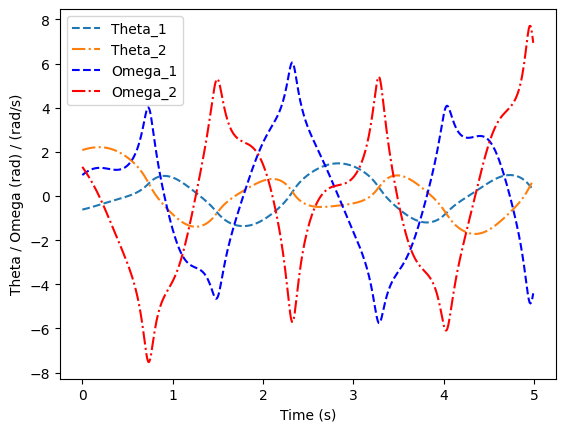

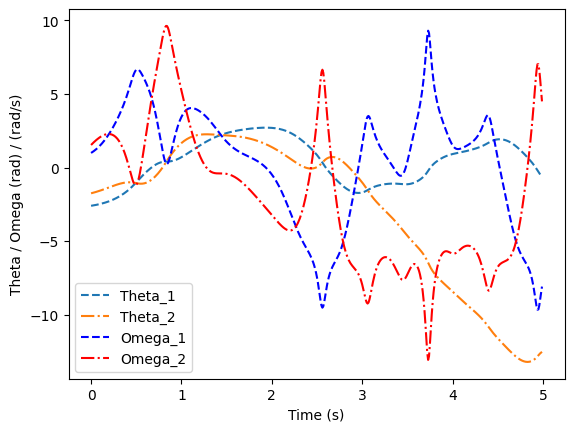

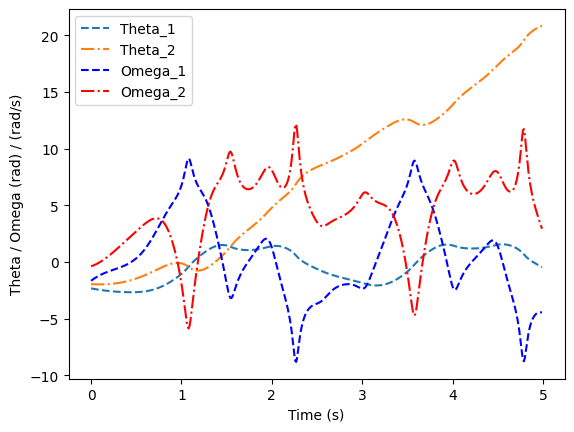

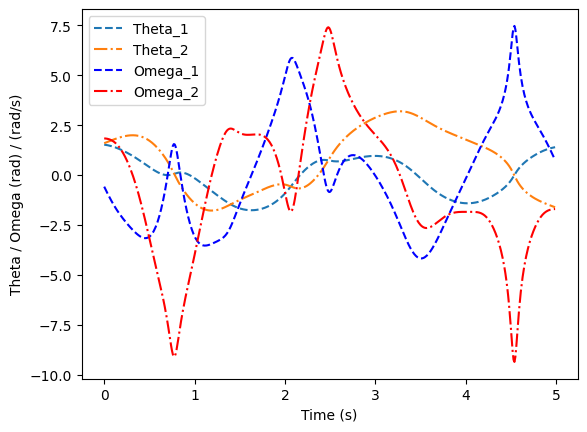

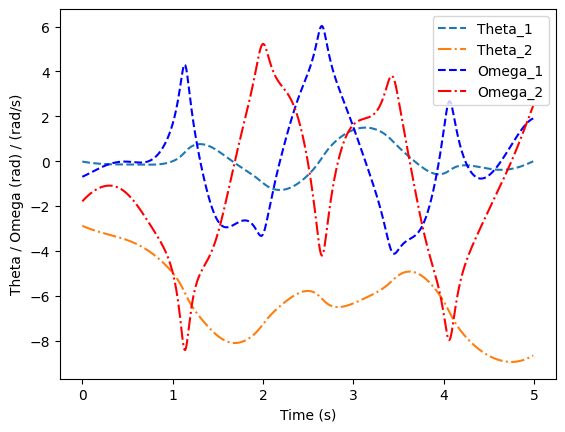

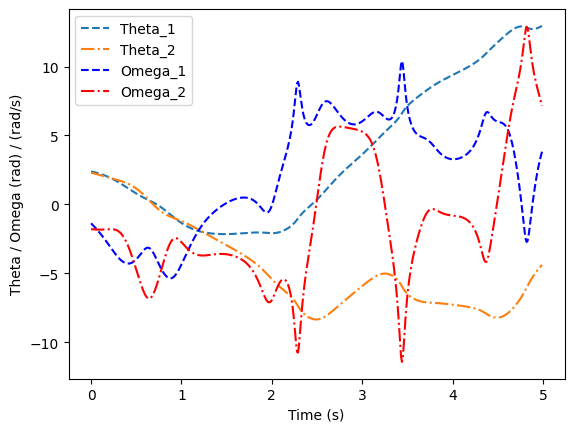

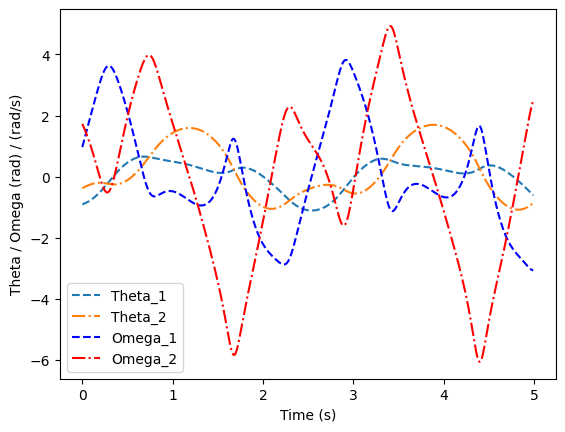

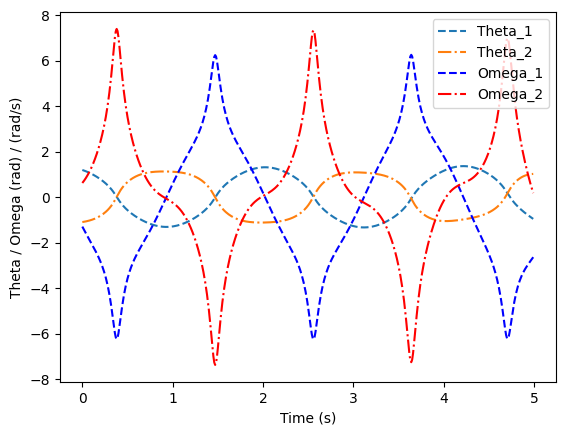

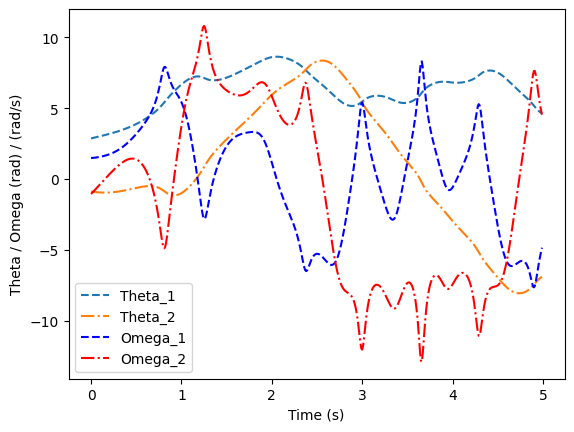

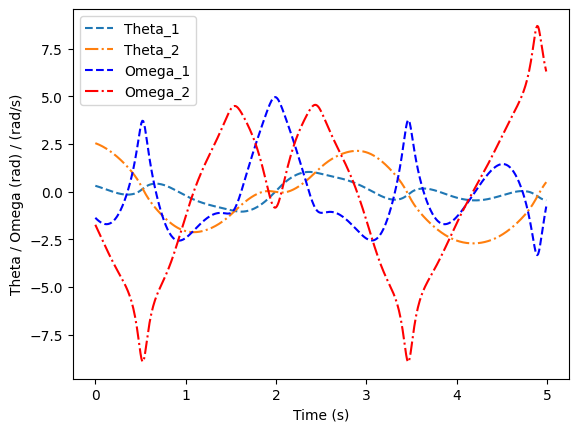

low energy
(500,)
(10000, 4)


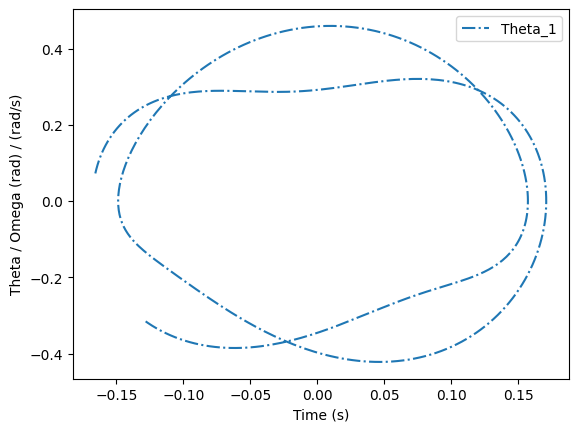

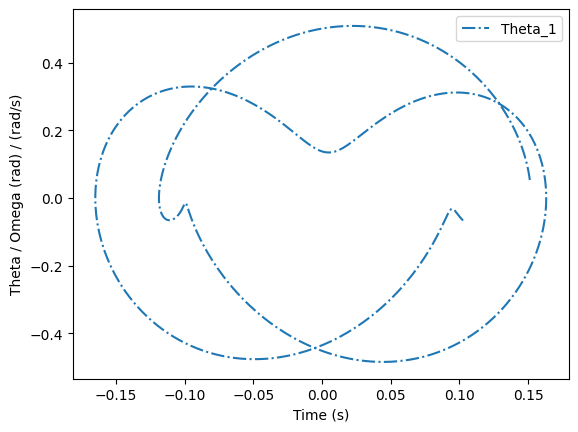

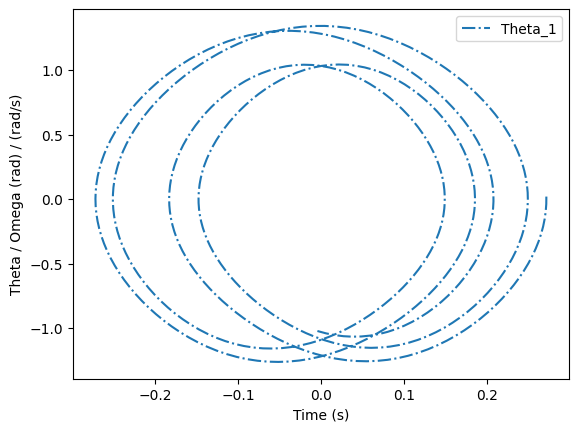

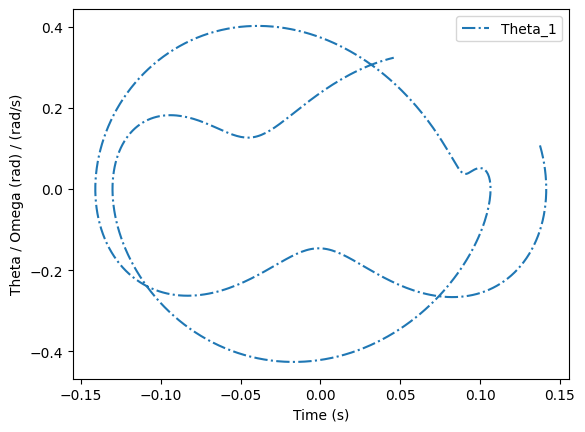

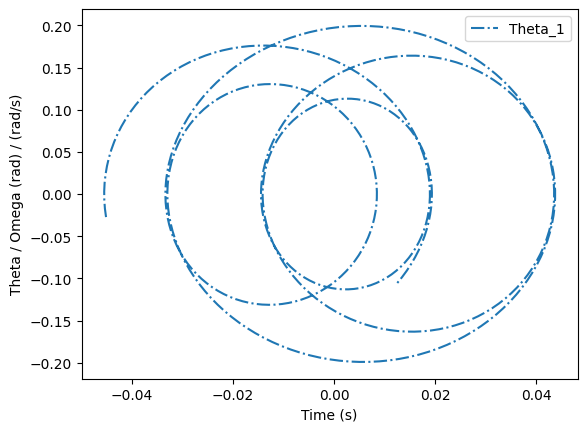

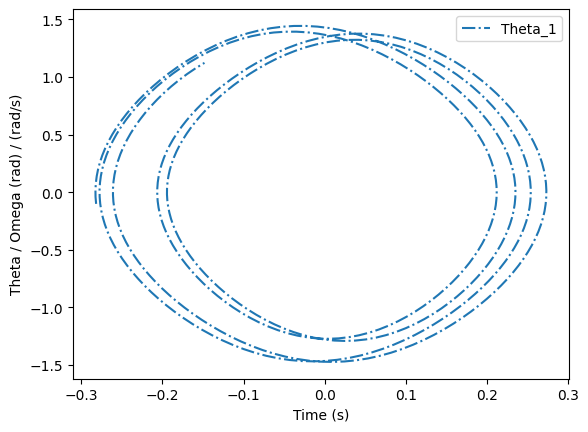

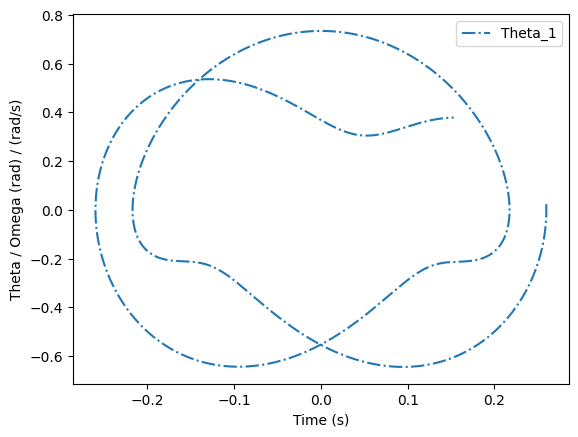

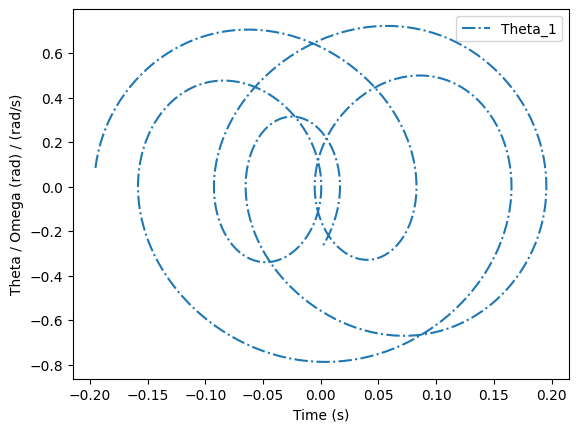

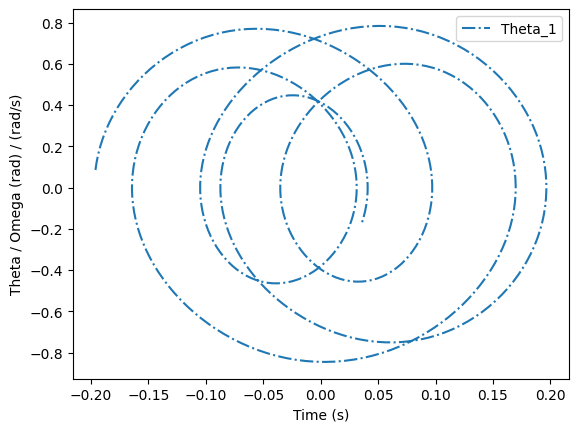

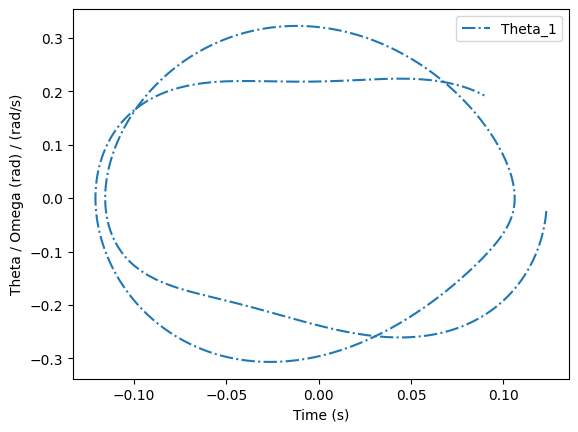

In [ ]:
#-----------------
# All energy plot
#-----------------

t = np.arange(start=0.0, stop=T, step=dt)
print(t.shape)
print(X.shape)
for k in range(int(n_traj/4)):
  plt.figure()
  plt.plot(t, X[k*500:(k+1)*500,0],"--")
  plt.plot(t, X[k*500:(k+1)*500,1],"-.")
  plt.plot(t, X[k*500:(k+1)*500,2],"--", color='blue')
  plt.plot(t, X[k*500:(k+1)*500,3],"-.", color = 'red')
  plt.xlabel("Time (s)")
  plt.ylabel("Theta / Omega (rad) / (rad/s)")
  plt.legend(["Theta_1", "Theta_2","Omega_1","Omega_2"])
  plt.show()

#-----------------
# Low energy plot
#-----------------

print("low energy")
t = np.arange(start=0.0, stop=T, step=dt)
print(t.shape)
print(X_low.shape)
for k in range(int(n_traj/4)):
  plt.figure()
  plt.plot(t, X_low[k*500:(k+1)*500,0],"--")
  plt.plot(t, X_low[k*500:(k+1)*500,1],"-.")
  plt.plot(t, X_low[k*500:(k+1)*500,2],"--", color='blue')
  plt.plot(t, X_low[k*500:(k+1)*500,3],"-.", color = 'red')
  plt.xlabel("Time (s)")
  plt.ylabel("Theta / Omega (rad) / (rad/s)")
  plt.legend(["Theta_1", "Theta_2","Omega_1","Omega_2"])
  plt.show()

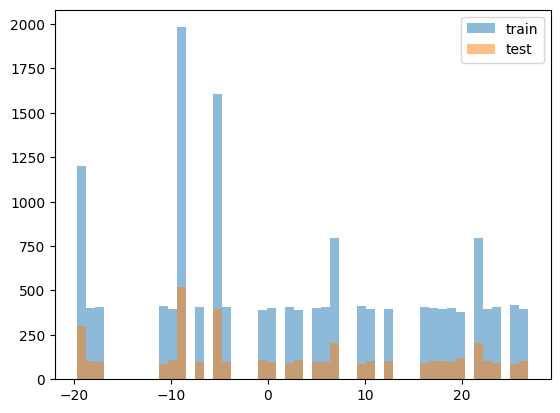

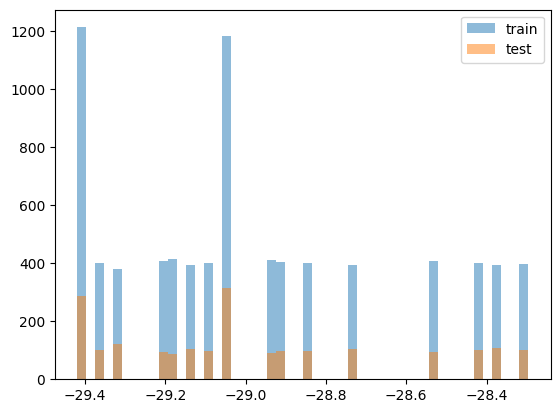

In [ ]:
#------------
# All energy
#------------

X_np = np.vstack(X)
theta1 = X_np[:,0]
theta2 = X_np[:,1]
omega1 = X_np[:,2]
omega2 = X_np[:,3]

m, l, g = params["m"], params["l"], params["g"]

T = (1/2) * m * l**2 * (2 * omega1**2 + omega2**2 + 2 * omega1 * omega2 * np.cos(theta1 - theta2))
V = -m * g * l * (2 * np.cos(theta1) + np.cos(theta2))
E = T + V

bins = np.quantile(E, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
E_bin = np.digitize(E, bins)

E_bin = np.digitize(E, bins=[0.1, 0.5, 1.0, 2.0, 4.0])

train_idx, test_idx = train_test_split(
    np.arange(len(X_np)),
    test_size=0.2,
    stratify=E_bin,
    random_state=42
)

plt.hist(E[train_idx], bins=50, alpha=0.5, label="train")
plt.hist(E[test_idx], bins=50, alpha=0.5, label="test")
plt.legend()
plt.show()

np.savez(
    "all_splits.npz",
    train_idx=train_idx,
    test_idx=test_idx
)

#------------
# Low energy
#------------

X_low_np = np.vstack(X_low)
theta1 = X_low_np[:,0]
theta2 = X_low_np[:,1]
omega1 = X_low_np[:,2]
omega2 = X_low_np[:,3]

m, l, g = params["m"], params["l"], params["g"]

T = (1/2) * m * l**2 * (2 * omega1**2 + omega2**2 + 2 * omega1 * omega2 * np.cos(theta1 - theta2))
V = -m * g * l * (2 * np.cos(theta1) + np.cos(theta2))
E = T + V

bins = np.quantile(E, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
E_bin = np.digitize(E, bins)

E_bin = np.digitize(E, bins=[0.1, 0.5, 1.0, 2.0, 4.0])

train_idx, test_idx = train_test_split(
    np.arange(len(X_low_np)),
    test_size=0.2,
    stratify=E_bin,
    random_state=42
)

plt.hist(E[train_idx], bins=50, alpha=0.5, label="train")
plt.hist(E[test_idx], bins=50, alpha=0.5, label="test")
plt.legend()
plt.show()

np.savez(
    "low_splits.npz",
    train_idx=train_idx,
    test_idx=test_idx
)

In [ ]:
#------------
# All energy
#------------


#-----------
# Load data
#-----------

data = np.load("all_dataset.npz")
split = np.load("all_splits.npz")

X = np.hstack(data["X"])
X = X.reshape(n_traj*500, 4)
Y = data["Y"]
Y = Y.reshape(n_traj*500, 4)
print(X.shape)
print(Y.shape)

#----------------
# Split data
#----------------

X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

theta1_train = X_train[:,0]
theta2_train = X_train[:,1]
omega1_train = X_train[:,2]
omega2_train = X_train[:,3]

dtheta1_train = Y_train[:,0]
dtheta2_train = Y_train[:,1]
domega1_train = Y_train[:,2]
domega2_train = Y_train[:,3]

theta1_test = X_test[:,0]
theta2_test = X_test[:,1]
omega1_test = X_test[:,2]
omega2_test = X_test[:,3]

dtheta1_test = Y_test[:,0]
dtheta2_test = Y_test[:,1]
domega1_test = Y_test[:,2]
domega2_test = Y_test[:,3]

#--------
# Save
#--------

np.savez(
         "double_pendulum_all_train.npz",
         theta1 = theta1_train,
         theta2 = theta2_train,
         omega1 = omega1_train,
         omega2 = omega2_train,
         dtheta1 = dtheta1_train,
         dtheta2 = dtheta2_train,
         domega1 = domega1_train,
         domega2 = domega2_train,
         dt=dt
         )

np.savez(
         "double_pendulum_all_test.npz",
         theta1 = theta1_test,
         theta2 = theta2_test,
         omega1 = omega1_test,
         omega2 = omega2_test,
         dtheta1 = dtheta1_test,
         dtheta2 = dtheta2_test,
         domega1 = domega1_test,
         domega2 = domega2_test,
         dt=dt
         )

(20000, 4)
(20000, 4)


In [ ]:
#------------
# Low energy
#------------


#-----------
# Load data
#-----------

data = np.load("low_dataset.npz")
split = np.load("low_splits.npz")

X = np.hstack(data["X"])
X = X.reshape(int(n_traj*500/2), 4)
Y = data["Y"]
Y = Y.reshape(int(n_traj*500/2), 4)
print(X.shape)
print(Y.shape)

#----------------
# Split data
#----------------

X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

theta1_train = X_train[:,0]
theta2_train = X_train[:,1]
omega1_train = X_train[:,2]
omega2_train = X_train[:,3]

dtheta1_train = Y_train[:,0]
dtheta2_train = Y_train[:,1]
domega1_train = Y_train[:,2]
domega2_train = Y_train[:,3]

theta1_test = X_test[:,0]
theta2_test = X_test[:,1]
omega1_test = X_test[:,2]
omega2_test = X_test[:,3]

dtheta1_test = Y_test[:,0]
dtheta2_test = Y_test[:,1]
domega1_test = Y_test[:,2]
domega2_test = Y_test[:,3]

#--------
# Save
#--------

np.savez(
         "double_pendulum_low_train.npz",
         theta1 = theta1_train,
         theta2 = theta2_train,
         omega1 = omega1_train,
         omega2 = omega2_train,
         dtheta1 = dtheta1_train,
         dtheta2 = dtheta2_train,
         domega1 = domega1_train,
         domega2 = domega2_train,
         dt=dt
         )

np.savez(
         "double_pendulum_low_test.npz",
         theta1 = theta1_test,
         theta2 = theta2_test,
         omega1 = omega1_test,
         omega2 = omega2_test,
         dtheta1 = dtheta1_test,
         dtheta2 = dtheta2_test,
         domega1 = domega1_test,
         domega2 = domega2_test,
         dt=dt
         )

(10000, 4)
(10000, 4)
